In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import wandb
import gc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
from collections import Counter
import random


In [2]:
wandb.login(key='b9247d458bf01da8c41dc1f576705259743348e1')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rv17richaverma (rv17richaverma-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Train Class Distribution:
  happy: 2320 images
  sad: 2320 images
  angry: 2320 images
Valid Class Distribution:
  happy: 560 images
  sad: 560 images
  angry: 560 images
Test Class Distribution:
  happy: 90 images
  sad: 90 images
  angry: 90 images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


Training ResNet18_Pretrained
ResNet18_Pretrained Epoch 1/20 - Train Loss: 0.8124, Valid Loss: 0.7083, Valid Accuracy: 0.6899
ResNet18_Pretrained Epoch 2/20 - Train Loss: 0.3578, Valid Loss: 0.6708, Valid Accuracy: 0.7143
ResNet18_Pretrained Epoch 3/20 - Train Loss: 0.2004, Valid Loss: 0.6910, Valid Accuracy: 0.7345
ResNet18_Pretrained Epoch 4/20 - Train Loss: 0.1472, Valid Loss: 0.6945, Valid Accuracy: 0.7411
ResNet18_Pretrained Epoch 5/20 - Train Loss: 0.1131, Valid Loss: 0.7370, Valid Accuracy: 0.7387
ResNet18_Pretrained Epoch 6/20 - Train Loss: 0.0993, Valid Loss: 0.7967, Valid Accuracy: 0.7333
Early stopping triggered at epoch 7
ResNet18_Pretrained Test - Overall Accuracy: 0.7185
Per-class Accuracies: Happy: 0.8936, Sad: 0.5769, Angry: 0.6944
Frame 1: happy - You're glowing with happiness!
Frame 2: happy - You're glowing with happiness!
Frame 3: happy - You're glowing with happiness!
Frame 4: happy - You're glowing with happiness!
Frame 5: happy - You're glowing with happiness!
Fra

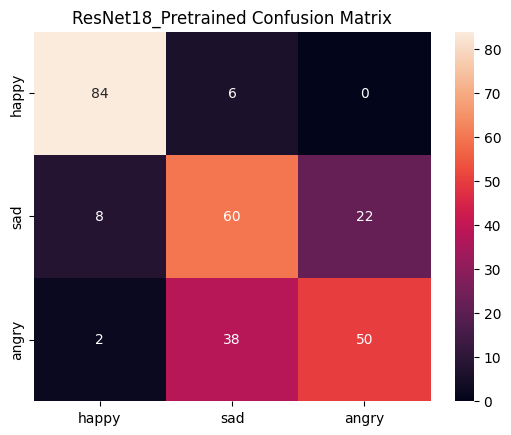

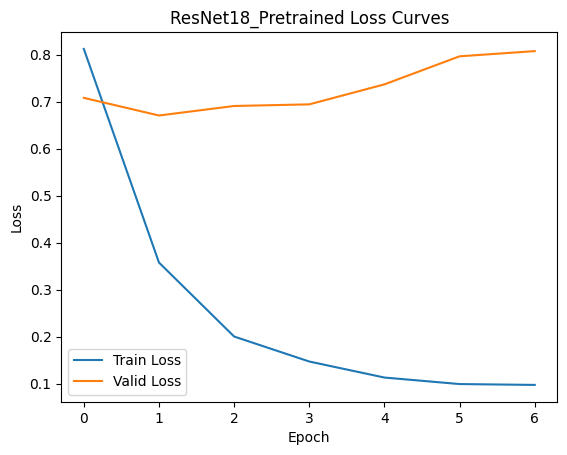

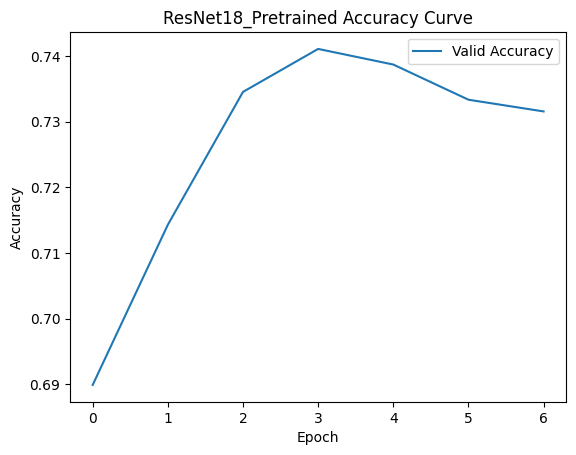

In [5]:

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize wandb
wandb.init(project="emotion_recognition_all", name="emotion_recognition_run")

# Custom Dataset (unchanged)
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = ['happy', 'sad', 'angry']
        for label, folder in enumerate(self.classes):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Augmentation (unchanged)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets and Check Class Balance (unchanged)
def check_class_balance(dataset, split_name):
    label_counts = Counter(dataset.labels)
    print(f"{split_name} Class Distribution:")
    for idx, count in label_counts.items():
        print(f"  {dataset.classes[idx]}: {count} images")
        if count < 50:
            print(f"  WARNING: {dataset.classes[idx]} has only {count} images, which may be too few for robust training.")
    return label_counts

train_dataset = EmotionDataset('/kaggle/input/emotion-data/emotion/train', transform=train_transform)
valid_dataset = EmotionDataset('/kaggle/input/emotion-data/emotion/valid', transform=valid_test_transform)
test_dataset = EmotionDataset('/kaggle/input/emotion-data/emotion/test', transform=valid_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_label_counts = check_class_balance(train_dataset, "Train")
valid_label_counts = check_class_balance(valid_dataset, "Valid")
test_label_counts = check_class_balance(test_dataset, "Test")

# Compute class weights (unchanged)
total_samples = sum(train_label_counts.values())
class_weights = torch.tensor([total_samples / (3 * train_label_counts[i]) for i in range(3)], dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Model Initialization Functions
def get_resnet18_pretrained():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 3)  # 3 emotion classes
    # Freeze first two convolutional blocks
    for param in list(model.parameters())[:20]:  # Approx first two blocks
        param.requires_grad = False
    return model

def get_resnet18_scratch():
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 3)  # 3 emotion classes
    # All parameters are trainable
    return model

def get_vggface_finetune():
    # Note: VGGFace is not directly available in torchvision. We'll use VGG16 as a proxy
    # and assume pretrained weights on VGGFace are loaded (you may need a custom implementation or library like torchvggface)
    model = models.vgg16(pretrained=True)  # Replace with VGGFace weights if available
    # Replace the final fully connected layer (originally binary or other) with 3 output neurons
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)  # 3 emotion classes
    # Freeze all layers except the classifier
    for param in model.features.parameters():
        param.requires_grad = False
    return model

# Training and Evaluation Function (unchanged, reused for all models)
def train_and_evaluate(model, model_name="ResNet18_Pretrained", epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    best_valid_loss = float('inf')
    patience = 5
    trigger_times = 0

    train_losses, valid_losses, valid_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        preds, true = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true.extend(labels.cpu().numpy())

        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        accuracy = accuracy_score(true, preds)
        valid_accuracies.append(accuracy)

        # Step scheduler and early stopping
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Log to wandb
        wandb.log({
            f"{model_name}_train_loss": train_loss,
            f"{model_name}_valid_loss": valid_loss,
            f"{model_name}_valid_accuracy": accuracy,
            "epoch": epoch
        })

        print(f"{model_name} Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}")

    # Test Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true, preds)
    report = classification_report(true, preds, target_names=['happy', 'sad', 'angry'], output_dict=True)
    class_accuracies = {cls: report[cls]['precision'] for cls in ['happy', 'sad', 'angry']}

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['happy', 'sad', 'angry'], yticklabels=['happy', 'sad', 'angry'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.savefig(f"{model_name}_cm.png")
    wandb.log({f"{model_name}_confusion_matrix": wandb.Image(f"{model_name}_cm.png")})

    # Log test metrics
    wandb.log({
        f"{model_name}_test_accuracy": accuracy,
        f"{model_name}_happy_accuracy": class_accuracies['happy'],
        f"{model_name}_sad_accuracy": class_accuracies['sad'],
        f"{model_name}_angry_accuracy": class_accuracies['angry']
    })

    print(f"{model_name} Test - Overall Accuracy: {accuracy:.4f}")
    print(f"Per-class Accuracies: Happy: {class_accuracies['happy']:.4f}, Sad: {class_accuracies['sad']:.4f}, Angry: {class_accuracies['angry']:.4f}")

    # Plot training curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{model_name}_loss_curve.png")
    wandb.log({f"{model_name}_loss_curve": wandb.Image(f"{model_name}_loss_curve.png")})

    plt.figure()
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.title(f"{model_name} Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{model_name}_accuracy_curve.png")
    wandb.log({f"{model_name}_accuracy_curve": wandb.Image(f"{model_name}_accuracy_curve.png")})

    # Creative Element: Display message based on emotion and log to wandb table
    emotion_table = wandb.Table(columns=["Frame", "Emotion", "Message"])
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            for j, pred in enumerate(preds):
                emotion = ['happy', 'sad', 'angry'][pred]
                message = {
                    'happy': "You're glowing with happiness!",
                    'sad': "It's okay, let the storm pass.",
                    'angry': "Take a deep breath, calm the fire!"
                }[emotion]
                frame_id = i*16+j+1
                print(f"Frame {frame_id}: {emotion} - {message}")
                emotion_table.add_data(frame_id, emotion, message)
            if i == 2:  # Limit for demo
                break

    wandb.log({f"{model_name}_emotion_messages": emotion_table})

    # Clean up
    torch.cuda.empty_cache()
    gc.collect()

# Run experiments for all models
# 1. ResNet18 Pretrained
model = get_resnet18_pretrained()
print("Training ResNet18_Pretrained")
train_and_evaluate(model, model_name="ResNet18_Pretrained")
# del model
# torch.cuda.empty_cache()
# gc.collect()




#wandb.finish()


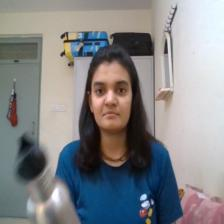

Finished inference for ResNet18_Pretrained!


In [6]:
import os
from PIL import Image
import torch
from torchvision import transforms
import time
from IPython.display import display, clear_output, HTML
import io
import base64
import numpy as np

def visualize_emotion_predictions(models, test_loader, class_names=['happy', 'sad', 'angry']):
    """
    Visualize predictions on test dataset for each emotion recognition model.
    Args:
        models: List of (model, model_name) tuples.
        test_loader: DataLoader for test dataset.
        class_names: List of class names corresponding to labels.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def get_image_html(img, title):
        """Convert PIL image to HTML for inline display with title"""
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_str}" width="224" height="224" style="object-fit: contain;">
            <p style="font-family: Arial; font-size: 14px; margin-top: 5px;">{title}</p>
        </div>
        """

    for model, model_name in emotion_models:
        print(f"\nPerforming inference with {model_name}...\n")
        model.to(device)
        model.eval()

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

            for img_tensor, gt_label, pred_label in zip(images, labels, preds):
                # Convert tensor image to PIL image for display
                img = img_tensor.cpu().permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img * 255, 0, 255).astype(np.uint8)
                img = Image.fromarray(img)

                gt_class = class_names[gt_label.item()]
                pred_class = class_names[pred_label.item()]
                title = f"GT: {gt_class} | Pred: {pred_class} | Model: {model_name}"

                # Display with HTML
                clear_output(wait=True)
                html_content = get_image_html(img, title)
                display(HTML(html_content))
                time.sleep(0.1)  # delay for visualization

        print(f"Finished inference for {model_name}!")


emotion_models = [
    (model, "ResNet18_Pretrained")
]

visualize_emotion_predictions(models, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training ResNet18_Scratch
ResNet18_Scratch Epoch 1/20 - Train Loss: 1.1385, Valid Loss: 1.1049, Valid Accuracy: 0.3446
ResNet18_Scratch Epoch 2/20 - Train Loss: 1.0713, Valid Loss: 1.1160, Valid Accuracy: 0.3524
ResNet18_Scratch Epoch 3/20 - Train Loss: 1.0438, Valid Loss: 1.1085, Valid Accuracy: 0.3696
ResNet18_Scratch Epoch 4/20 - Train Loss: 1.0008, Valid Loss: 1.1741, Valid Accuracy: 0.3881
ResNet18_Scratch Epoch 5/20 - Train Loss: 0.9597, Valid Loss: 1.1663, Valid Accuracy: 0.3881
Early stopping triggered at epoch 6
ResNet18_Scratch Test - Overall Accuracy: 0.3704
Per-class Accuracies: Happy: 0.3810, Sad: 0.3333, Angry: 0.6667
Frame 1: happy - You're glowing with happiness!
Frame 2: happy - You're glowing with happiness!
Frame 3: sad - It's okay, let the storm pass.
Frame 4: happy - You're glowing with happiness!
Frame 5: happy - You're glowing with happiness!
Frame 6: happy - You're glowing with happiness!
Frame 7: sad - It's okay, let the storm pass.
Frame 8: happy - You're glow

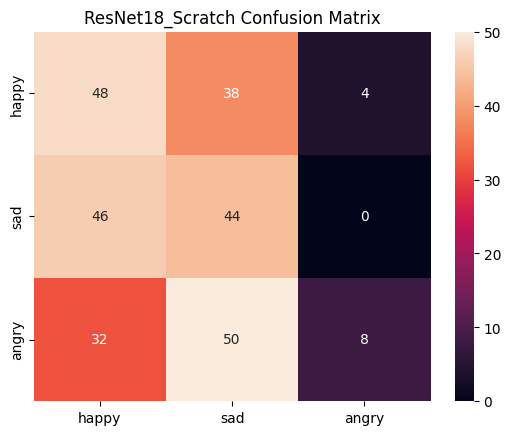

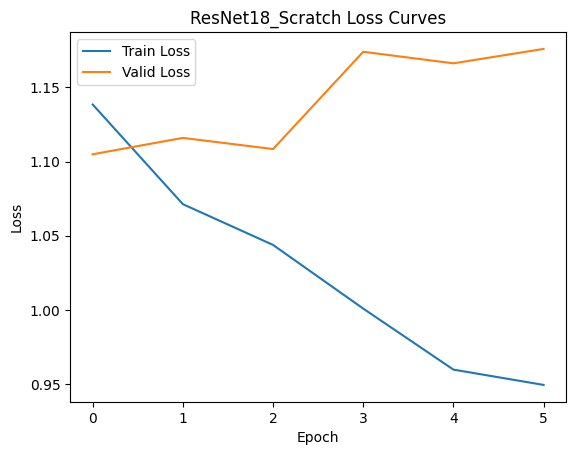

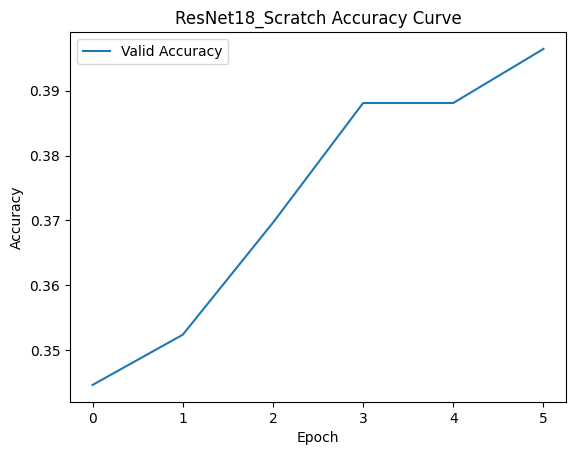

In [7]:
# Model 2
# Training and Evaluation Function (unchanged, reused for all models)
def train_and_evaluate(model, model_name="ResNet18_Pretrained", epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    best_valid_loss = float('inf')
    patience = 5
    trigger_times = 0

    train_losses, valid_losses, valid_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        preds, true = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true.extend(labels.cpu().numpy())

        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        accuracy = accuracy_score(true, preds)
        valid_accuracies.append(accuracy)

        # Step scheduler and early stopping
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Log to wandb
        wandb.log({
            f"{model_name}_train_loss": train_loss,
            f"{model_name}_valid_loss": valid_loss,
            f"{model_name}_valid_accuracy": accuracy,
            "epoch": epoch
        })

        print(f"{model_name} Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}")

    # Test Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true, preds)
    report = classification_report(true, preds, target_names=['happy', 'sad', 'angry'], output_dict=True)
    class_accuracies = {cls: report[cls]['precision'] for cls in ['happy', 'sad', 'angry']}

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['happy', 'sad', 'angry'], yticklabels=['happy', 'sad', 'angry'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.savefig(f"{model_name}_cm.png")
    wandb.log({f"{model_name}_confusion_matrix": wandb.Image(f"{model_name}_cm.png")})

    # Log test metrics
    wandb.log({
        f"{model_name}_test_accuracy": accuracy,
        f"{model_name}_happy_accuracy": class_accuracies['happy'],
        f"{model_name}_sad_accuracy": class_accuracies['sad'],
        f"{model_name}_angry_accuracy": class_accuracies['angry']
    })

    print(f"{model_name} Test - Overall Accuracy: {accuracy:.4f}")
    print(f"Per-class Accuracies: Happy: {class_accuracies['happy']:.4f}, Sad: {class_accuracies['sad']:.4f}, Angry: {class_accuracies['angry']:.4f}")

    # Plot training curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{model_name}_loss_curve.png")
    wandb.log({f"{model_name}_loss_curve": wandb.Image(f"{model_name}_loss_curve.png")})

    plt.figure()
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.title(f"{model_name} Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{model_name}_accuracy_curve.png")
    wandb.log({f"{model_name}_accuracy_curve": wandb.Image(f"{model_name}_accuracy_curve.png")})

    # Creative Element: Display message based on emotion and log to wandb table
    emotion_table = wandb.Table(columns=["Frame", "Emotion", "Message"])
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            for j, pred in enumerate(preds):
                emotion = ['happy', 'sad', 'angry'][pred]
                message = {
                    'happy': "You're glowing with happiness!",
                    'sad': "It's okay, let the storm pass.",
                    'angry': "Take a deep breath, calm the fire!"
                }[emotion]
                frame_id = i*16+j+1
                print(f"Frame {frame_id}: {emotion} - {message}")
                emotion_table.add_data(frame_id, emotion, message)
            if i == 2:  # Limit for demo
                break

    wandb.log({f"{model_name}_emotion_messages": emotion_table})

    # Clean up
    torch.cuda.empty_cache()
    gc.collect()

    # 2. ResNet18 From Scratch
model = get_resnet18_scratch()
print("Training ResNet18_Scratch")
train_and_evaluate(model, model_name="ResNet18_Scratch")


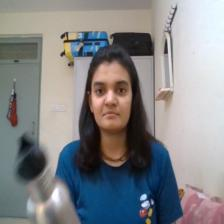

Finished inference for ResNet18_Scratch!


In [8]:
import os
from PIL import Image
import torch
from torchvision import transforms
import time
from IPython.display import display, clear_output, HTML
import io
import base64
import numpy as np

def visualize_emotion_predictions(models, test_loader, class_names=['happy', 'sad', 'angry']):
    """
    Visualize predictions on test dataset for each emotion recognition model.
    Args:
        models: List of (model, model_name) tuples.
        test_loader: DataLoader for test dataset.
        class_names: List of class names corresponding to labels.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def get_image_html(img, title):
        """Convert PIL image to HTML for inline display with title"""
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_str}" width="224" height="224" style="object-fit: contain;">
            <p style="font-family: Arial; font-size: 14px; margin-top: 5px;">{title}</p>
        </div>
        """

    for model, model_name in emotion_models2:
        print(f"\nPerforming inference with {model_name}...\n")
        model.to(device)
        model.eval()

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

            for img_tensor, gt_label, pred_label in zip(images, labels, preds):
                # Convert tensor image to PIL image for display
                img = img_tensor.cpu().permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img * 255, 0, 255).astype(np.uint8)
                img = Image.fromarray(img)

                gt_class = class_names[gt_label.item()]
                pred_class = class_names[pred_label.item()]
                title = f"GT: {gt_class} | Pred: {pred_class} | Model: {model_name}"

                # Display with HTML
                clear_output(wait=True)
                html_content = get_image_html(img, title)
                display(HTML(html_content))
                time.sleep(0.1)  # delay for visualization

        print(f"Finished inference for {model_name}!")


emotion_models2 = [
    (model, "ResNet18_Scratch")
]

visualize_emotion_predictions(models, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s] 


Training VGGFace_Finetune
VGGFace_Finetune Epoch 1/20 - Train Loss: 1.0553, Valid Loss: 1.0577, Valid Accuracy: 0.4458
VGGFace_Finetune Epoch 2/20 - Train Loss: 0.8853, Valid Loss: 1.0397, Valid Accuracy: 0.4393
VGGFace_Finetune Epoch 3/20 - Train Loss: 0.7442, Valid Loss: 0.9943, Valid Accuracy: 0.5173
VGGFace_Finetune Epoch 4/20 - Train Loss: 0.6374, Valid Loss: 1.0130, Valid Accuracy: 0.5381
VGGFace_Finetune Epoch 5/20 - Train Loss: 0.5644, Valid Loss: 0.9679, Valid Accuracy: 0.5762
VGGFace_Finetune Epoch 6/20 - Train Loss: 0.5060, Valid Loss: 0.9794, Valid Accuracy: 0.6065
VGGFace_Finetune Epoch 7/20 - Train Loss: 0.4654, Valid Loss: 0.9235, Valid Accuracy: 0.6268
VGGFace_Finetune Epoch 8/20 - Train Loss: 0.4274, Valid Loss: 0.8821, Valid Accuracy: 0.6411
VGGFace_Finetune Epoch 9/20 - Train Loss: 0.4037, Valid Loss: 0.8550, Valid Accuracy: 0.6423
VGGFace_Finetune Epoch 10/20 - Train Loss: 0.3774, Valid Loss: 0.8852, Valid Accuracy: 0.6542
VGGFace_Finetune Epoch 11/20 - Train Loss: 

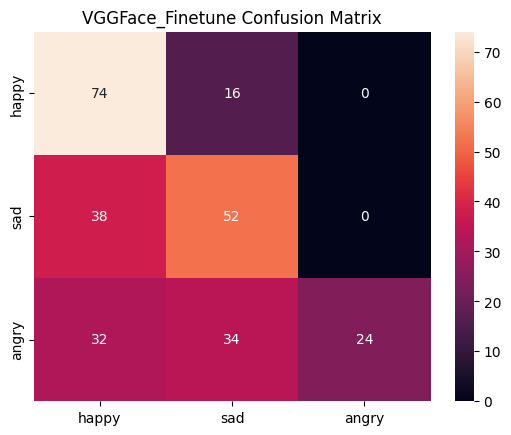

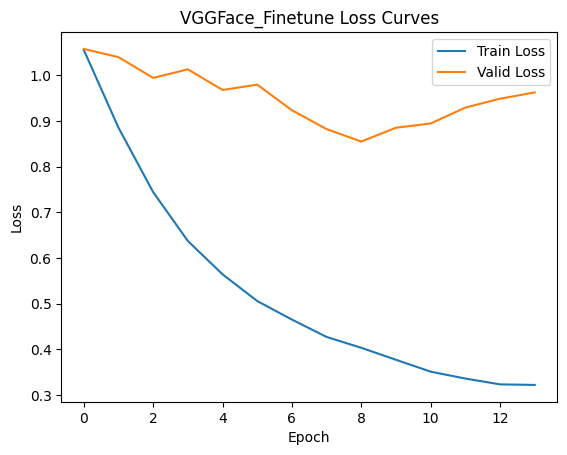

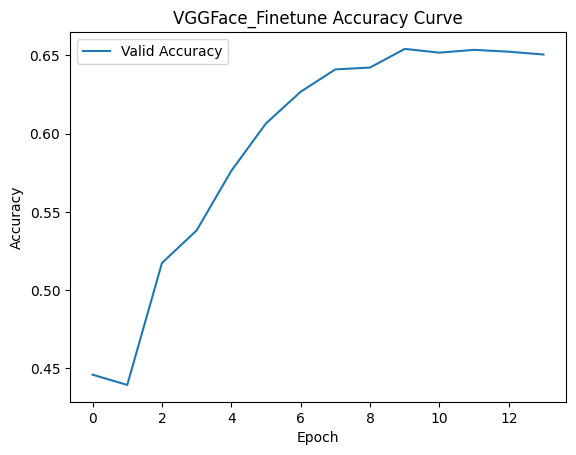

In [9]:
# Model 3
# Training and Evaluation Function 
def train_and_evaluate(model, model_name="VGGFace_Finetune", epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    best_valid_loss = float('inf')
    patience = 5
    trigger_times = 0

    train_losses, valid_losses, valid_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        preds, true = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true.extend(labels.cpu().numpy())

        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        accuracy = accuracy_score(true, preds)
        valid_accuracies.append(accuracy)

        # Step scheduler and early stopping
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Log to wandb
        wandb.log({
            f"{model_name}_train_loss": train_loss,
            f"{model_name}_valid_loss": valid_loss,
            f"{model_name}_valid_accuracy": accuracy,
            "epoch": epoch
        })

        print(f"{model_name} Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}")

    # Test Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true, preds)
    report = classification_report(true, preds, target_names=['happy', 'sad', 'angry'], output_dict=True)
    class_accuracies = {cls: report[cls]['precision'] for cls in ['happy', 'sad', 'angry']}

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['happy', 'sad', 'angry'], yticklabels=['happy', 'sad', 'angry'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.savefig(f"{model_name}_cm.png")
    wandb.log({f"{model_name}_confusion_matrix": wandb.Image(f"{model_name}_cm.png")})

    # Log test metrics
    wandb.log({
        f"{model_name}_test_accuracy": accuracy,
        f"{model_name}_happy_accuracy": class_accuracies['happy'],
        f"{model_name}_sad_accuracy": class_accuracies['sad'],
        f"{model_name}_angry_accuracy": class_accuracies['angry']
    })

    print(f"{model_name} Test - Overall Accuracy: {accuracy:.4f}")
    print(f"Per-class Accuracies: Happy: {class_accuracies['happy']:.4f}, Sad: {class_accuracies['sad']:.4f}, Angry: {class_accuracies['angry']:.4f}")

    # Plot training curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{model_name}_loss_curve.png")
    wandb.log({f"{model_name}_loss_curve": wandb.Image(f"{model_name}_loss_curve.png")})

    plt.figure()
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.title(f"{model_name} Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{model_name}_accuracy_curve.png")
    wandb.log({f"{model_name}_accuracy_curve": wandb.Image(f"{model_name}_accuracy_curve.png")})

    # Creative Element: Display message based on emotion and log to wandb table
    emotion_table = wandb.Table(columns=["Frame", "Emotion", "Message"])
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            for j, pred in enumerate(preds):
                emotion = ['happy', 'sad', 'angry'][pred]
                message = {
                    'happy': "You're glowing with happiness!",
                    'sad': "It's okay, let the storm pass.",
                    'angry': "Take a deep breath, calm the fire!"
                }[emotion]
                frame_id = i*16+j+1
                print(f"Frame {frame_id}: {emotion} - {message}")
                emotion_table.add_data(frame_id, emotion, message)
            if i == 2:  # Limit for demo
                break

    wandb.log({f"{model_name}_emotion_messages": emotion_table})

    # Clean up
    torch.cuda.empty_cache()
    gc.collect()
    # 3. VGGFace Finetuning
model = get_vggface_finetune()
print("Training VGGFace_Finetune")
train_and_evaluate(model, model_name="VGGFace_Finetune")


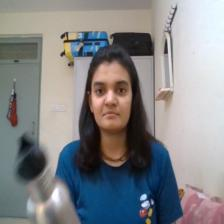

Finished inference for VGGFace_Finetune!


In [10]:
import os
from PIL import Image
import torch
from torchvision import transforms
import time
from IPython.display import display, clear_output, HTML
import io
import base64
import numpy as np

def visualize_emotion_predictions(models, test_loader, class_names=['happy', 'sad', 'angry']):
    """
    Visualize predictions on test dataset for each emotion recognition model.
    Args:
        models: List of (model, model_name) tuples.
        test_loader: DataLoader for test dataset.
        class_names: List of class names corresponding to labels.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def get_image_html(img, title):
        """Convert PIL image to HTML for inline display with title"""
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_str}" width="224" height="224" style="object-fit: contain;">
            <p style="font-family: Arial; font-size: 14px; margin-top: 5px;">{title}</p>
        </div>
        """

    for model, model_name in emotion_models2:
        print(f"\nPerforming inference with {model_name}...\n")
        model.to(device)
        model.eval()

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

            for img_tensor, gt_label, pred_label in zip(images, labels, preds):
                # Convert tensor image to PIL image for display
                img = img_tensor.cpu().permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img * 255, 0, 255).astype(np.uint8)
                img = Image.fromarray(img)

                gt_class = class_names[gt_label.item()]
                pred_class = class_names[pred_label.item()]
                title = f"GT: {gt_class} | Pred: {pred_class} | Model: {model_name}"

                # Display with HTML
                clear_output(wait=True)
                html_content = get_image_html(img, title)
                display(HTML(html_content))
                time.sleep(0.1)  # delay for visualization

        print(f"Finished inference for {model_name}!")


emotion_models2 = [
    (model, "VGGFace_Finetune")
]

visualize_emotion_predictions(models, test_loader)
